In [26]:
##Ben Pelto October 2019

# Python imports
import os
import pandas as pd
import salem
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer
- 7 Castle Creek

In [27]:
num = 2 #num determines which gdir and gradient to use

#data points gradients
grad = [6.84, 9.8, 7.11, 9.8, 10.84, 6.01, 7.92, 7.19] # mm w.e. m-1 

products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer', 'Castle']
# Get the RGI IDs for the run.
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780', 'RGI60-02.08783']

In [28]:
WORKING_DIR = utils.get_temp_dir('velocity_test' + glacier[num])
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

2019-10-29 15:02:20: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [29]:
cfg.PARAMS['border'] = 10
if glacier[num] == 'W.Washmawapta' or 'Nordic':
    cfg.PARAMS['use_intersects'] = False

In [30]:
rgidf = utils.get_rgi_glacier_entities([rgi_list[num]]) # Get a list of glacier outlines selected by RGI IDs
gdirs = workflow.init_glacier_regions(rgidf) # Initializes the list of Glacier Directories for this run
workflow.gis_prepro_tasks(gdirs)        # runs all flowline preprocessing tasks
workflow.climate_tasks(gdirs)           # runs all climate related tasks
# workflow.inversion_tasks(gdirs)         #runs all ice thickness inversion tasks
gdir = gdirs[0]
tasks.prepare_for_inversion(gdir, add_debug_var=True)
tasks.mass_conservation_inversion(gdir)
tasks.filter_inversion_output(gdir)
# workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
# tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

2019-10-29 15:02:21: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-10-29 15:02:21: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-10-29 15:02:22: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-10-29 15:02:22: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-10-29 15:02:22: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-10-29 15:02:22: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-10-29 15:02:22: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-10-29 15:02:22: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-10-29 15:02:23: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anacon

In [31]:
# @entity_task(log, writes=['inversion_output'])
def compute_velocities(gdir, glen_a=None, fs=None, filesuffix=''):
    """Surface velocities along the flowlines from inverted ice thickness.
    Computed following the methods described in
    Cuffey and Paterson (2010) Eq. 8.35, pp 310:
        u_s = u_basal + (2A/n+1)* tau^n * H
    In the case of no sliding:
        u_z/u_s = [n+1]/[n+2] = 0.8 if n = 3.
    The output is written in 'inversion_output.pkl' in m yr-1
    You'll need to call prepare_for_inversion with the `add_debug_var=True`
    kwarg for this to work!
    Parameters
    ----------
    gdir : Glacier directory
    with_sliding : bool
        default is True, if set to False will not add the sliding component.
    filesuffix : str
        add a suffix to the output file
    """

    # Defaults
    if glen_a is None:
        glen_a = cfg.PARAMS['inversion_glen_a']
    if fs is None:
        fs = cfg.PARAMS['inversion_fs']

    rho = cfg.PARAMS['ice_density']
    glen_n = cfg.PARAMS['glen_n']

    # Getting the data for the main flowline
    cls = gdir.read_pickle('inversion_output')

    for cl in cls:
        # vol in m3 and dx in m
        section = cl['volume'] / cl['dx']

        # this flux is in m3 per second
        flux = cl['flux']
        angle = cl['slope_angle']
        thick = cl['thick']

        if fs > 0:
            tau = rho * cfg.G * angle * thick

            with warnings.catch_warnings():
                # This can trigger a divide by zero Warning
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                u_basal = fs * tau ** glen_n / thick

            u_basal[~np.isfinite(u_basal)] = 0

            u_deformation = (2 * glen_a / (glen_n + 1)) * (tau**glen_n) * thick

            u_basal *= cfg.SEC_IN_YEAR
            u_deformation *= cfg.SEC_IN_YEAR
            u_surface = u_basal + u_deformation

            velocity = flux / section
            velocity *= cfg.SEC_IN_YEAR
        else:
            # velocity in cross section
            fac = (glen_n + 1) / (glen_n + 2)
            velocity = flux / section
            velocity *= cfg.SEC_IN_YEAR
            u_surface = velocity / fac
            u_basal = velocity * 0
            u_deformation = velocity * 0

        # output
        cl['u_integrated'] = velocity
        cl['u_surface'] = u_surface
        cl['u_basal'] = u_basal
        cl['u_deformation'] = u_deformation

    gdir.write_pickle(cls, 'inversion_output', filesuffix=filesuffix)

In [32]:
compute_velocities(gdir)

In [33]:
# ds = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
# ds.close() 

In [34]:
# pkl = gdir.read_pickle('inversion_input')
cl = gdir.read_pickle('inversion_output')[-1]
cl

{'dx': 136.0,
 'flux_a0': array([1.56786397e-05, 2.89008634e-05, 3.77367235e-05, 4.51888607e-05,
        4.68800311e-05, 4.13633730e-05, 3.90755665e-05, 4.49814133e-05,
        5.73635624e-05, 7.12196635e-05, 8.43818290e-05, 9.57530914e-05,
        1.02354003e-04, 1.09652615e-04, 1.24282203e-04, 1.48191994e-04,
        1.71648029e-04, 1.85788506e-04, 1.92778634e-04, 1.87709815e-04,
        1.75436353e-04, 1.72261248e-04, 1.72737916e-04, 1.59380120e-04,
        1.38325812e-04, 1.24342725e-04, 1.16045659e-04, 1.06696906e-04,
        6.70992652e-05, 7.01551189e-05, 7.99341493e-05, 8.87915891e-05,
        9.70324648e-05, 1.08565122e-04, 1.17526268e-04, 1.22681380e-04,
        1.24843129e-04, 1.21394182e-04, 1.04270272e-04, 8.01533171e-05,
        6.55872396e-05, 6.45960315e-05, 7.65287561e-05, 1.34869369e-04,
        1.45381639e-04, 1.54092299e-04, 1.57670864e-04, 1.54029666e-04,
        1.48278799e-04, 1.44200055e-04, 1.41301288e-04, 1.32338854e-04,
        1.02477130e-04, 6.87247872e-05,

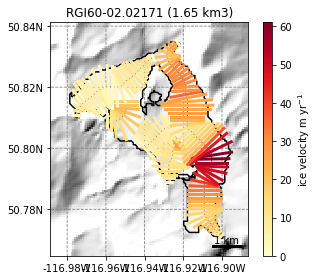

In [35]:
import graphics2
graphics2.plot_inversion(gdirs, data='u_surface', label='ice velocity m yr$^{-1}$')
plt.savefig('/home/pelto/Desktop/velocity_mapping/products/conrad_ice_velocity.png', dpi=300)

In [36]:
# inv = gdir.read_pickle('inversion_input')[-1]
# inv

In [37]:
# gdir.read_pickle('inversion_input').info(verbose=True)